PyGSLIB
========

Introduction
---------------

This is a simple example on how to use raw pyslib to compute variograms with gridded data



In [1]:
#general imports
import matplotlib.pyplot as plt  
import pygslib as gslib                  #gslib with raw interface to __fgslib 

#make the plots inline
%matplotlib inline  

Getting the data ready for work
---------

You can use [Pandas](http://pandas.pydata.org/) to import your data from csv, execel, sql database, json, html, among others. If the data is in GSLIB format you can use the function `gslib.read_gslib_file(filename)` to import the data into a Pandas datagrame. 


In [2]:
#get the data in gslib format into a pandas Dataframe
mydata= gslib.read_gslib_file('true.dat')  #I'm using the file in pygslib/datasets.

In [3]:
# This is a 2D grid file with two variables in addition we need a 
# dummy BHID = 1 (this is like domain to avoid creating pairs from apples and oranges)
mydata['bhid']=1

# printing to verify results
print ' \n **** 5 first rows in my datafile \n\n  ', mydata.tail(n=5)


 
 **** 5 first rows in my datafile 

            U     V  bhid
2495  7.11  8.82     1
2496  9.26  7.97     1
2497  1.86  8.62     1
2498  1.12  6.59     1
2499  1.65  5.83     1


## Testing variogram function gamv

This is the example in the book GSLIB User Guide (Problem set two: variograms). The variogram parameter file (modified) may look like this in gslib:


                      Parameters for GAM
                      ******************

    START OF PARAMETERS:
    true.dat      -file with data
    2   1   2             -   number of variables, column numbers
    -1.0e21     1.0e21    -   trimming limits
    gam.out               -file for variogram output
    1                     -grid or realization number
    50   0.5   1.0        -nx, xmn, xsiz
    50   0.5   1.0        -ny, ymn, ysiz
     1   0.5   1.0        -nz, zmn, zsiz
    2  10                 -number of directions, number of lags
     1  0  0              -ixd(1),iyd(1),izd(1)
     0  1  0              -ixd(2),iyd(2),izd(2)
    1                     -standardize sill? (0=no, 1=yes)
    4                     -number of variograms
    1   1   1             -tail variable, head variable, variogram type
    1   1   3             -tail variable, head variable, variogram type
    2   2   1             -tail variable, head variable, variogram type
    2   2   3             -tail variable, head variable, variogram type




 > Note: The indicator variograms are not implemented in the fortran module. The user may define externally the indicator variables and run variogram (type 1) for indicator variography



In [4]:
mydata[['V']].var()

V    7.321597
dtype: float32

In [15]:
# these are the parameters we need. Note that at difference of GSLIB this dictionary also stores 
# the actual data 
#important! python is case sensitive 'bhid' is not equal to 'BHID'

# the program gam (fortran code) use flatten array of 2D arrays (unlike gamv which 
# works with 2D arrays). This is a work araound to input the data in the right format
# WARNING: this is only for GAM and make sure you use FORTRAN order. 
vr=mydata[['U', 'V']].values.flatten(order='FORTRAN')
U_var= mydata[['U']].var()
V_var= mydata[['V']].var()


parameters = { 
        'nx'     :  50,                     # number of rows in the gridded data
        'ny'     :  50,                     # number of columns in the gridded data
        'nz'     :  1,                      # number of levels in the gridded data
        'xsiz'   :  1,                      # size of the cell in x direction 
        'ysiz'   :  1,                      # size of the cell in y direction
        'zsiz'   :  1,                      # size of the cell in z direction
        'bhid'   :  mydata['bhid'],         # bhid for downhole variogram, array('i') with bounds (nd)    
        'vr'     :  vr,     # Variables, array('f') with bounds (nd,nv), nv is number of variables
        'tmin'   : -1.0e21,                 # trimming limits, float
        'tmax'   :  1.0e21,                 # trimming limits, float
        'nlag'   :  10,                     # number of lags, int
        'ixd'    : [1,0],                   # directiom x 
        'iyd'    : [0,1],                   # directiom y 
        'izd'    : [0,0],                   # directiom z 
        'isill'  : 1,                       # standardize sills? (0=no, 1=yes), int
        'sills'  : [U_var, V_var],          # variance used to std the sills, array('f') with bounds (nv)
        'ivtail' : [1,1,2,2],               # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
        'ivhead' : [1,1,2,2],               # head var., array('i') with bounds (nvarg)
        'ivtype' : [1,3,1,3]}               # variogram type, array('i') with bounds (nvarg)

'''
Reamember this is GSLIB... use this code to define variograms
type 1 = traditional semivariogram
     2 = traditional cross semivariogram
     3 = covariance
     4 = correlogram
     5 = general relative semivariogram
     6 = pairwise relative semivariogram
     7 = semivariogram of logarithms
     8 = semimadogram

'''              

#check the variogram is ok
#TODO: assert gslib.check_gam_par(parameters)==1 , 'sorry this parameter file is wrong' 


'\nReamember this is GSLIB... use this code to define variograms\ntype 1 = traditional semivariogram\n     2 = traditional cross semivariogram\n     3 = covariance\n     4 = correlogram\n     5 = general relative semivariogram\n     6 = pairwise relative semivariogram\n     7 = semivariogram of logarithms\n     8 = semimadogram\n\n'

In [16]:
#Now we are ready to calculate the veriogram
pdis,pgam, phm,ptm,phv,ptv,pnump= gslib.gam(parameters)

print pgam

[[[  0.49099764   0.62729055   0.75956219   0.81880862   0.83166933
     0.88927311   0.93925202   0.96531963   1.0060029    0.99574864   0.
     0.        ]
  [  0.49539953   0.63302124   0.67525107   0.72280204   0.75413489
     0.83415318   0.859326     0.89247763   0.87174916   0.89095002   0.
     0.        ]]

 [[ 12.69870186   9.05096436   5.38965654   3.70148301   3.67338443
     2.57339644   1.7060107    1.53730965   0.82611686   1.2450403    0.
     0.        ]
  [ 13.02353859   9.25504017   6.19592237   5.13208818   4.56865311
     2.819839     1.58864796   0.71644157   0.18400018  -0.36678225   0.
     0.        ]]

 [[  0.04456483   0.15066791   0.30093884   0.46583912   0.61244023
     0.7248674    0.79961342   0.84148175   0.85618436   0.85477775   0.
     0.        ]
  [  0.04343615   0.1386285    0.27413827   0.43363869   0.59783477
     0.73311895   0.84416115   0.92843354   0.98325098   0.99413007   0.
     0.        ]]

 [[  6.71178484   5.72430563   4.47947788   3.

The output is a set of 3d arrays (pdis,pgam, phm,ptm,phv,ptv,pnump) with dimensions (nvarg, ndir, nlag+2), representing the experimental variograms output, and 1D array (cldi, cldj, cldg, cldh) representing variogram cloud for first variogram/direction.

> This structure is complex but is like the standalone GSLIB gamv program. 

To plot the variograms we need to use pdis (pair distances) and  pgam (variogram values). Reamember this arrays are 3D, to use the right values keep in mind that:

- dim 0 is the variogram number 
- dim 1 is the direction
- dim 2 is the lag

the number of variograms, directions and lags can be calculated as follows:

In [17]:
nvrg = pdis.shape[0]
ndir = pdis.shape[1]
nlag = pdis.shape[2]-2

print 'nvrg: ', nvrg, '\nndir: ', ndir, '\nnlag: ', nlag

nvrg:  4 
ndir:  2 
nlag:  10


Comparing results with GSLIB output
--------------------

This is the first variogram output from gslib (direction 1 and 2)


    Semivariogram           tail:U            head:U             direction  1 
       1        1.000      0.49119     2450        2.53364        2.53909
       2        2.000      0.62754     2400        2.49753        2.52300
       3        3.000      0.75987     2350        2.46945        2.50771
       4        4.000      0.81914     2300        2.45293        2.49312
       5        5.000      0.83200     2250        2.46641        2.49146
       6        6.000      0.88963     2200        2.48491        2.50075
       7        7.000      0.93963     2150        2.50757        2.52079
       8        8.000      0.96571     2100        2.53510        2.53821
       9        9.000      1.00641     2050        2.55013        2.56459
      10       10.000      0.99615     2000        2.57868        2.55968
      
      
      
    Semivariogram           tail:U            head:U             direction  2 
       1        1.000      0.49560     2450        2.61572        2.51775
       2        2.000      0.63327     2400        2.64921        2.45918
       3        3.000      0.67552     2350        2.68369        2.37889
       4        4.000      0.72309     2300        2.72356        2.34000
       5        5.000      0.75444     2250        2.75722        2.31314
       6        6.000      0.83449     2200        2.79176        2.30304
       7        7.000      0.85967     2150        2.78771        2.27861
       8        8.000      0.89283     2100        2.78614        2.25039
       9        9.000      0.87210     2050        2.79200        2.17433
      10       10.000      0.89131     2000        2.81165        2.15231
 

In [18]:
import pandas as pd
variogram=0
dir1=0
dir2=1

pd.DataFrame({'dis1': pdis[variogram, dir1, : -2], 
 'gam1': pgam[variogram, dir1, : -2], 
 'npr1': pnump[variogram, dir1, : -2], 
 'dis2': pdis[variogram, dir2, : -2], 
 'gam2': pgam[variogram, dir2, : -2], 
 'npr2': pnump[variogram, dir2, : -2]})

,dis1,dis2,gam1,gam2,npr1,npr2
0,1,1,0.490998,0.495400,2450,2450
1,2,2,0.627291,0.633021,2400,2400
2,3,3,0.759562,0.675251,2350,2350
3,4,4,0.818809,0.722802,2300,2300
4,5,5,0.831669,0.754135,2250,2250
5,6,6,0.889273,0.834153,2200,2200
6,7,7,0.939252,0.859326,2150,2150
7,8,8,0.965320,0.892478,2100,2100
8,9,9,1.006003,0.871749,2050,2050
9,10,10,0.995749,0.890950,2000,2000


Plotting the results
-----------------------

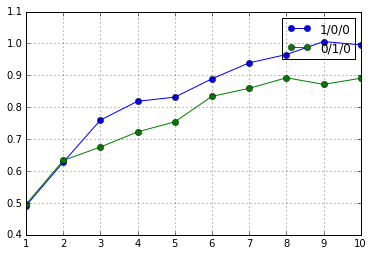

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

#ploting the variogram 1 only
v=0

# in all the directions calculated
for d in range(ndir):
    ixd=parameters['ixd'][d]
    iyd=parameters['iyd'][d]
    izd=parameters['izd'][d]
    plt.plot (pdis[v, d, :-2], pgam[v, d, :-2], '-o', label=str(ixd) + '/' + str(iyd) + '/' + str(izd))

# adding nice features to the plot
plt.legend()
plt.grid(True)
plt.show()
